Número de produtos: 10, Número de reviews: 50


c:\Users\Yuri_\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Yuri_\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling ba

Embeddings criados: torch.Size([50, 768])


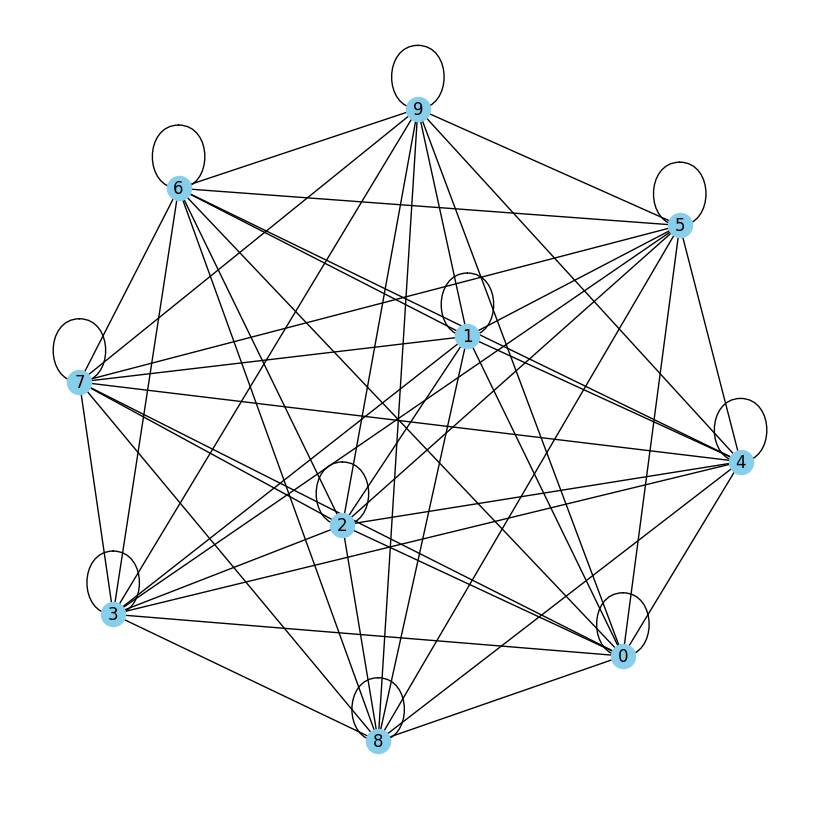

Epoch 10/50 - Loss: 1.2229
Epoch 20/50 - Loss: 0.5282
Epoch 30/50 - Loss: 0.5728
Epoch 40/50 - Loss: 0.4809
Epoch 50/50 - Loss: 0.3175
Recomendado para você: [7 0 5]


In [ ]:
# Projeto Local: Recomendação de Produtos (100% offline)

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Criar dataset local fictício
# -----------------------------
reviews = [
    "I loved this product! It works perfectly and the quality is amazing.",
    "Terrible experience. The product broke after a day.",
    "Good value for the price, satisfied with the purchase.",
    "Not what I expected, quite disappointing.",
    "Excellent! Exceeded my expectations.",
    "Poor quality, would not recommend.",
    "Amazing product, very happy!",
    "Worst purchase ever, completely useless.",
    "Really good, works as described.",
    "Bad, do not buy this."
]

# Criar DataFrame com 10 produtos e 50 reviews
data = []
for i in range(10):
    for j in range(5):  # 5 reviews por produto
        text = np.random.choice(reviews)
        rating = 5 if "good" in text.lower() or "love" in text.lower() or "excellent" in text.lower() or "amazing" in text.lower() else 2
        data.append([i, text, rating])
df = pd.DataFrame(data, columns=['product_id','review_body','star_rating'])

# Encode do produto
le = LabelEncoder()
df['product_idx'] = le.fit_transform(df['product_id'])
products = df['product_idx'].unique()
print(f"Número de produtos: {len(products)}, Número de reviews: {len(df)}")

# -----------------------------
# NLP: Embeddings com DistilBERT
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=64)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:,0,:]

embeddings = torch.cat([get_embedding(txt) for txt in df['review_body']], dim=0)
print("Embeddings criados:", embeddings.shape)

# -----------------------------
# Grafo de produtos (NetworkX)
# -----------------------------
G = nx.Graph()
G.add_nodes_from(products)

threshold = 0.9  # alto para poucos nós
for i in range(len(df)):
    for j in range(i+1, len(df)):
        sim = F.cosine_similarity(embeddings[i].unsqueeze(0), embeddings[j].unsqueeze(0))
        if sim > threshold:
            G.add_edge(df.iloc[i]['product_idx'], df.iloc[j]['product_idx'])

plt.figure(figsize=(8,8))
nx.draw(G, with_labels=True, node_size=300, node_color='skyblue')
plt.show()

# -----------------------------
# Features médias por produto
# -----------------------------
product_features = []
product_targets = []

for p in products:
    idxs = df[df['product_idx']==p].index
    avg_emb = embeddings[idxs].mean(dim=0)
    product_features.append(avg_emb)
    product_targets.append(df[df['product_idx']==p]['star_rating'].mean())

X = torch.stack(product_features)
y = torch.tensor(product_targets, dtype=torch.float)

# -----------------------------
# MLP para previsão de nota
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()

model = MLP(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    out = model(X)
    loss = loss_fn(out, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/50 - Loss: {loss.item():.4f}")

# -----------------------------
# Função de recomendação
# -----------------------------
def recommend_product(review_text, top_k=3):
    emb = get_embedding(review_text)
    similarities = []
    for pf in product_features:
        sim = F.cosine_similarity(emb, pf.unsqueeze(0))
        similarities.append(sim.item())
    
    top_idx = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:top_k]
    recommended_products = le.inverse_transform(top_idx)
    return recommended_products

# -----------------------------
# 7️⃣ Teste: nova review
# -----------------------------
new_review = "I loved this product! It works perfectly and the quality is amazing."
recommendations = recommend_product(new_review)
print("Recomendado para você:", recommendations)


Número de produtos: 10, Número de reviews: 50
Embeddings criados: torch.Size([50, 768])


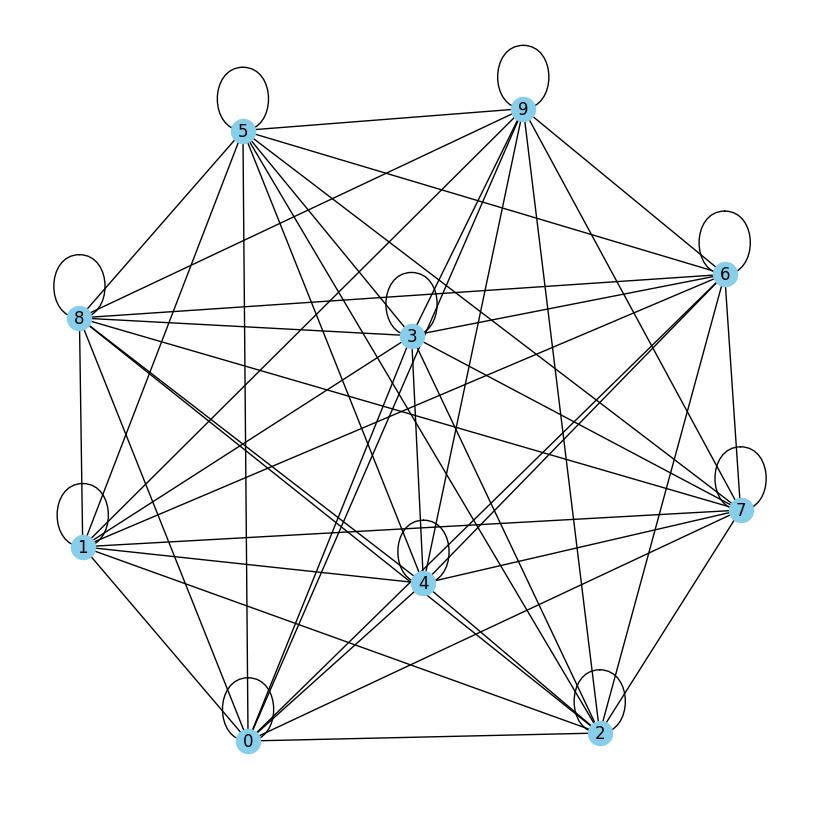

Epoch 10/50 - Loss: 0.5789
Epoch 20/50 - Loss: 0.7196
Epoch 30/50 - Loss: 0.4305
Epoch 40/50 - Loss: 0.2178
Epoch 50/50 - Loss: 0.4226
Recomendado para você: [0 5 4]


In [ ]:
# Projeto Local Completo: Recomendação de Produtos (100% offline, com batches)

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# Criar dataset local fictício
# -----------------------------
reviews = [
    "I loved this product! It works perfectly and the quality is amazing.",
    "Terrible experience. The product broke after a day.",
    "Good value for the price, satisfied with the purchase.",
    "Not what I expected, quite disappointing.",
    "Excellent! Exceeded my expectations.",
    "Poor quality, would not recommend.",
    "Amazing product, very happy!",
    "Worst purchase ever, completely useless.",
    "Really good, works as described.",
    "Bad, do not buy this."
]

data = []
for i in range(10):        # 10 produtos
    for j in range(5):     # 5 reviews por produto
        text = np.random.choice(reviews)
        rating = 5 if any(k in text.lower() for k in ["good", "love", "excellent", "amazing"]) else 2
        data.append([i, text, rating])

df = pd.DataFrame(data, columns=['product_id','review_body','star_rating'])

# Encode do produto
le = LabelEncoder()
df['product_idx'] = le.fit_transform(df['product_id'])
products = df['product_idx'].unique()
print(f"Número de produtos: {len(products)}, Número de reviews: {len(df)}")

# -----------------------------
# NLP: Embeddings com DistilBERT em batches
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")

def get_embedding(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=64)
    with torch.no_grad():
        output = bert_model(**tokens)
    return output.last_hidden_state[:,0,:]

def get_batch_embeddings(texts, batch_size=8):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_embs = torch.cat([get_embedding(txt) for txt in batch_texts], dim=0)
        all_embeddings.append(batch_embs)
    return torch.cat(all_embeddings, dim=0)

embeddings = get_batch_embeddings(df['review_body'].tolist())
print("Embeddings criados:", embeddings.shape)

# -----------------------------
# Grafo de produtos (NetworkX)
# -----------------------------
G = nx.Graph()
G.add_nodes_from(products)

threshold = 0.9
for i in range(len(df)):
    for j in range(i+1, len(df)):
        sim = F.cosine_similarity(embeddings[i].unsqueeze(0), embeddings[j].unsqueeze(0))
        if sim > threshold:
            G.add_edge(df.iloc[i]['product_idx'], df.iloc[j]['product_idx'])

plt.figure(figsize=(8,8))
nx.draw(G, with_labels=True, node_size=300, node_color='skyblue')
plt.show()

# -----------------------------
# Features médias por produto
# -----------------------------
product_features = []
product_targets = []

for p in products:
    idxs = df[df['product_idx']==p].index
    avg_emb = embeddings[idxs].mean(dim=0)
    product_features.append(avg_emb)
    product_targets.append(df[df['product_idx']==p]['star_rating'].mean())

X = torch.stack(product_features)
y = torch.tensor(product_targets, dtype=torch.float)

# -----------------------------
# MLP para previsão de nota
# -----------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()

model = MLP(input_dim=X.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Criando DataLoader para batch training
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Treinamento em batches
for epoch in range(50):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        out = model(batch_X)
        loss = loss_fn(out, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/50 - Loss: {epoch_loss/len(dataloader):.4f}")

# -----------------------------
# Função de recomendação
# -----------------------------
def recommend_product(review_text, top_k=3):
    emb = get_embedding(review_text)
    similarities = []
    for pf in product_features:
        sim = F.cosine_similarity(emb, pf.unsqueeze(0))
        similarities.append(sim.item())
    
    top_idx = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)[:top_k]
    recommended_products = le.inverse_transform(top_idx)
    return recommended_products

# -----------------------------
#  Teste: nova review
# -----------------------------
new_review = "I loved this product! It works perfectly and the quality is amazing."
recommendations = recommend_product(new_review)
print("Recomendado para você:", recommendations)
